# State Reducers

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

### Default overwriting state

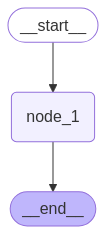

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image , display
from langgraph.graph import StateGraph , START , END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state["foo"] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1" , node_1)

# Logic
builder.add_edge(START , "node_1")
builder.add_edge("node_1" , END)

# Add 
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"foo": 1})

---Node 1---


{'foo': 2}

### Branching

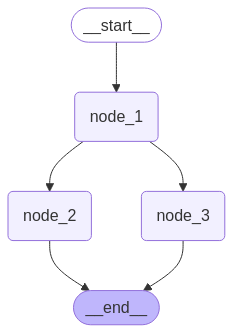

In [4]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


### Reducers

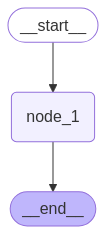

In [11]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int] , add]


def node_1(state):
    print("---Node 1---")
    return {"foo": [state["foo"][-1] + 1]}

#Build graph
builder = StateGraph(State)
builder.add_node("node_1" , node_1)

# Logic
builder.add_edge(START , "node_1")
builder.add_edge("node_1" , END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))



In [13]:
graph.invoke({"foo": [1]})

---Node 1---


{'foo': [1, 2]}

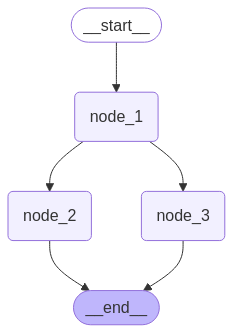

In [16]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke({"foo": [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

In [18]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


### Custom Reducers

In [19]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

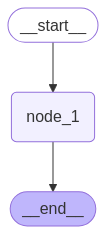

TypeError occurred: can only concatenate list (not "NoneType") to list


In [20]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

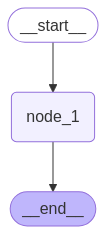

---Node 1---
{'foo': [2]}


In [21]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

### Messages

In [22]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

In [23]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='12377a95-8ad1-4d73-b3fc-1911bc3aeba1'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='9621b3e7-ed91-4645-9879-e385fcede06d'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='fe3e160f-b6af-428c-973e-b554635ff019')]

### Re-writing

In [24]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### Removal

In [25]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [26]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]